In [1]:
#Needed modules
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K
import keras_tuner as kt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import datetime

from sklearn.preprocessing import MinMaxScaler
import func

from IPython.display import clear_output


from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

Using TensorFlow backend


In [2]:
batch_size=32
log_dir="../Models/Temp/" + datetime.datetime.now().strftime("%m-%d-%H-%S")

In [3]:
#get data set
df=pd.read_csv("../Data/BBRI1year.csv").iloc[:,1]

In [4]:
#Rescale the data to the range of 0-to-1
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(df.values.reshape(-1,1))
df=scaler.transform(df.values.reshape(-1,1))

In [5]:
#split into 9|3
temp=9*30
train=df[:temp]; test=df[temp:]

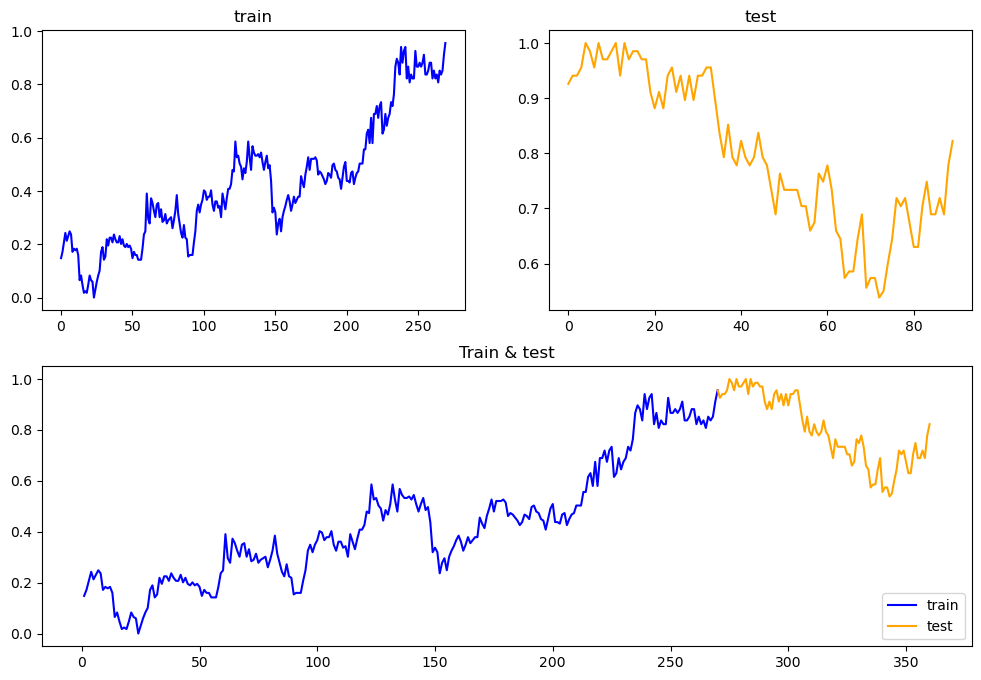

In [6]:
func.plottraintest(train, test)

In [7]:
# reshape into X=t and Y=t+1
t=30
trainX, trainY = func.lag(train,t)
testX, testY = func.lag(test,t)

In [8]:
# reshape input to be [samples, features, time steps] so it can be fitted in the model
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [9]:
#callback
def tensorboardlogger():
    return [keras.callbacks.ModelCheckpoint(log_dir+"/callbacks", save_weights_only=True),
            tf.keras.callbacks.TensorBoard(log_dir)]
    
class SelectiveProgbarLogger(tf.keras.callbacks.ProgbarLogger):
    def __init__(self, verbose, totepochs, epoch_interval, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.default_verbose = verbose
        self.epoch_interval = epoch_interval
        self.totepochs=totepochs
    
    def on_epoch_begin(self, epoch, *args, **kwargs):
        self.verbose = (
            0 
                if epoch % self.epoch_interval != 0 
                else self.default_verbose
        )
        if epoch==self.totepochs-1:
            clear_output()
        super().on_epoch_begin(epoch, *args, **kwargs)

In [10]:
def theplot(history):
    fig = plt.figure(figsize=(15,13))
    ax=fig.add_subplot(3,2,1)
    ax.plot(history.history["mean_absolute_error"], label="mean_absolute_error", c="blue")
    ax.set_xlabel("epochs")
    ax.set_ylabel("mean_absolute_error")
    ax.legend(loc="upper right")
    ax.set_ylim(0,0.1)
    
    ax=fig.add_subplot(3,2,2)
    ax.plot(history.history["val_mean_absolute_percentage_error"], label="val_mean_absolute_percentage_error", c="orange")
    ax.set_xlabel("epochs")
    ax.set_ylabel("mean_absolute_error")
    ax.legend(loc="upper right")
    ax.set_ylim(0,20)
    
    ax=fig.add_subplot(3,1,2)
    ax.plot(history.history["loss"], label="mean_squared_error", c="blue")
    ax.plot(history.history["val_loss"], label="val_mean_squared_error", c="orange")
    ax.legend(loc="upper right")
    ax.set_ylim(0,0.01)
    ax.set_xlabel("epochs")
    ax.set_ylabel("MSE")
    
    ax=fig.add_subplot(3,1,3)
    ax.plot(history.history["mean_absolute_percentage_error"], label="mean_absolute_percentage_error", c="blue")
    ax.legend(loc="lower right")
    ax.set_xlabel("epochs")
    ax.set_ylabel("MAPE")
    ax.plot(history.history["val_mean_absolute_percentage_error"], label="val_mean_absolute_percentage_error", c="orange")
    ax.legend(loc="upper right")
    ax.set_xlabel("epochs")
    ax.set_ylabel("MAPE")
    ax.set_ylim(0,30)

In [11]:
#Load
model=keras.models.load_model("../Models/First.keras")

In [115]:
#create model
def getmodel_compile():
    model=keras.Sequential([
        
        keras.layers.LSTM(4, input_shape=(t, 1), return_sequences=True),                   #input and 1st layer
        keras.layers.LSTM(8),                                                              #2nd layer
        keras.layers.Dense(1)])                                                                                             #output (pakai 1 karena output berbentuk regresi)
    
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.MeanAbsolutePercentageError()])
    return model

In [153]:
model=getmodel_compile()

epoch=1000
thehistory=model.fit(trainX, trainY, epochs=epoch, validation_data=(testX, testY), 
                     batch_size=batch_size, verbose=0,
                     callbacks=[tensorboardlogger(), SelectiveProgbarLogger(verbose=1, epoch_interval=1, totepochs=epoch)])

Epoch 1000/1000
8/8 [==============================] - 0s 22ms/sample - loss: 0.0015 - mean_absolute_error: 0.0301 - mean_absolute_percentage_error: 7.8856 - val_loss: 0.0023 - val_mean_absolute_error: 0.0389 - val_mean_absolute_percentage_error: 5.5182


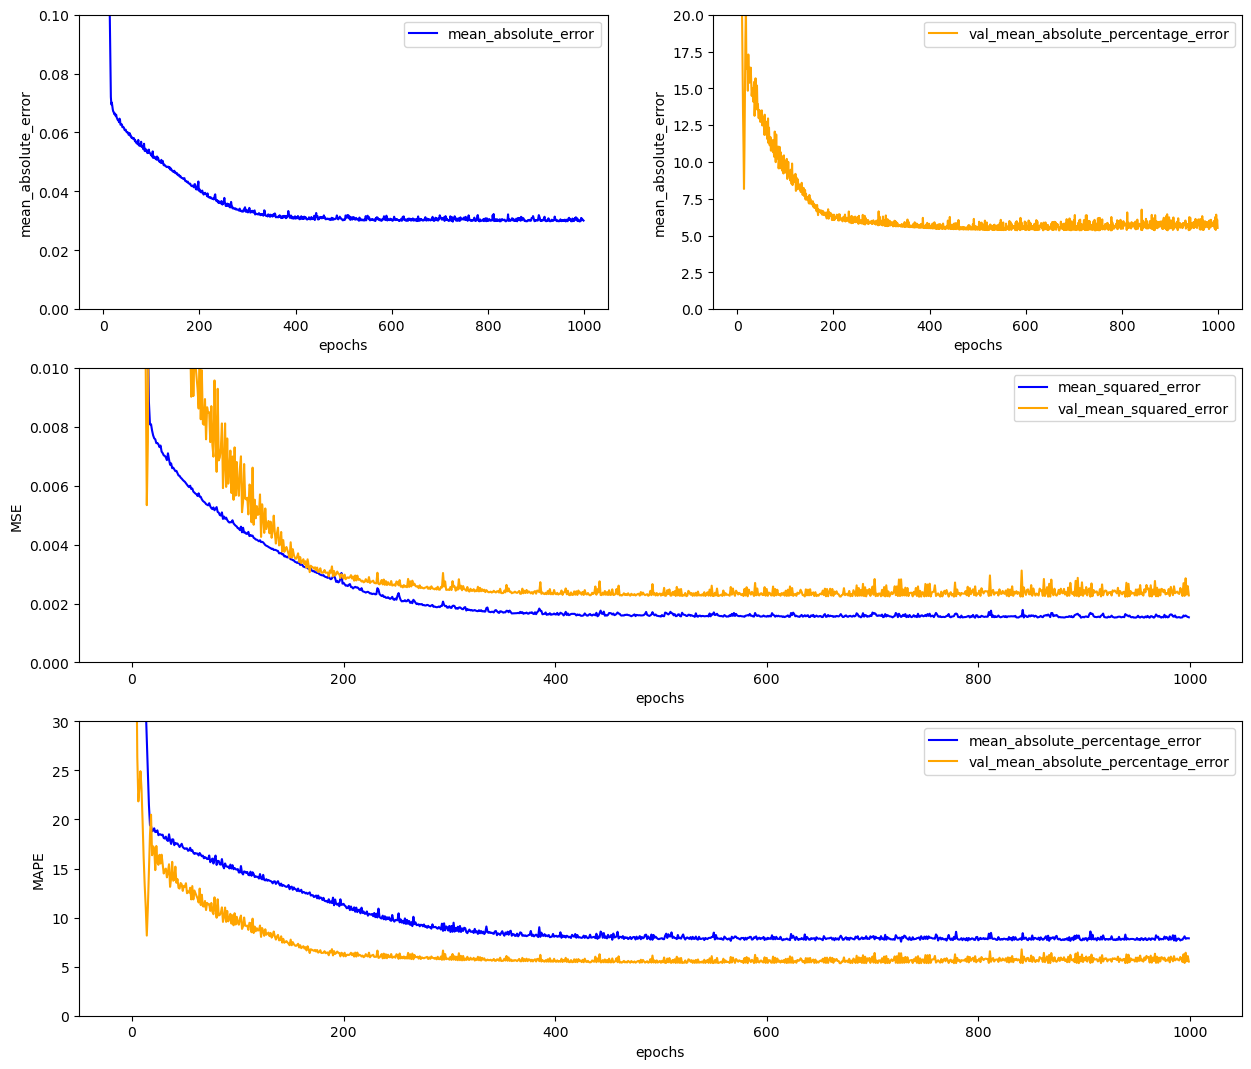

In [154]:
theplot(thehistory)

In [14]:
#predict
trainPredict = model.predict(trainX, batch_size=batch_size).reshape(1, -1)
testPredict = model.predict(testX, batch_size=batch_size).reshape(1, -1)

2/2 [==============================] - 0s 7ms/step


In [15]:
# invert scale
trainPredict = scaler.inverse_transform(trainPredict).flatten()
testPredict = scaler.inverse_transform(testPredict).flatten()


testY = scaler.inverse_transform([testY]).flatten()
trainY = scaler.inverse_transform([trainY]).flatten()

In [16]:
#Metrics
pd.DataFrame(list(zip([mean_absolute_percentage_error(trainY, trainPredict), np.sqrt(mean_squared_error(trainY, trainPredict))],
                      [mean_absolute_percentage_error(testY, testPredict), np.sqrt(mean_squared_error(testY, testPredict))])),
             columns=["Train", "Test"], index=["MAPE", "RMSE"])

,Train,Test
MAPE,0.010581,0.012589
RMSE,66.263015,80.642330


In [17]:
#transform back!
testY = scaler.transform(testY.reshape(-1,1)).flatten()
trainY = scaler.transform(trainY.reshape(-1,1)).flatten()

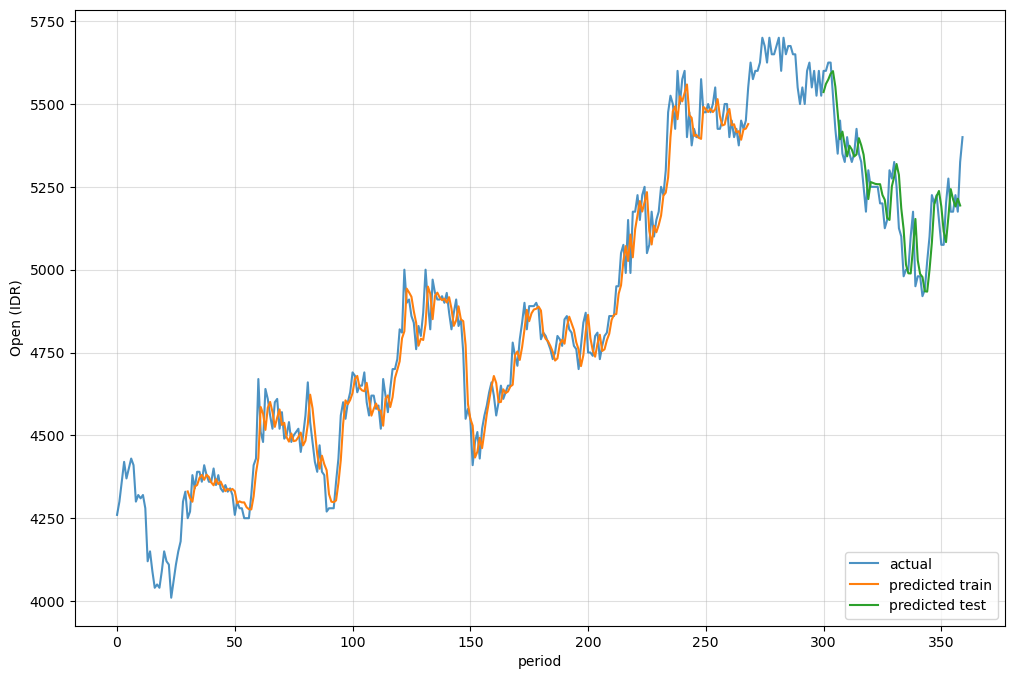

In [18]:
#Predict vs actual!
func.plot_predicted(scaler.inverse_transform(df), 
                    trainPredict.reshape(-1,1), 
                    testPredict.reshape(-1,1), t)

In [178]:
model.save("../Models/First.keras")

In [19]:
#Go tuning? Nah idk!11 ALLAT too lazy for that!


#Forecasting the next 60 days

iwannaforecast=60
z=func.forecast(predictedday=iwannaforecast, model=model, scaler=scaler, testdata=test, t=t)

Text(0.5, 0, 'Period')

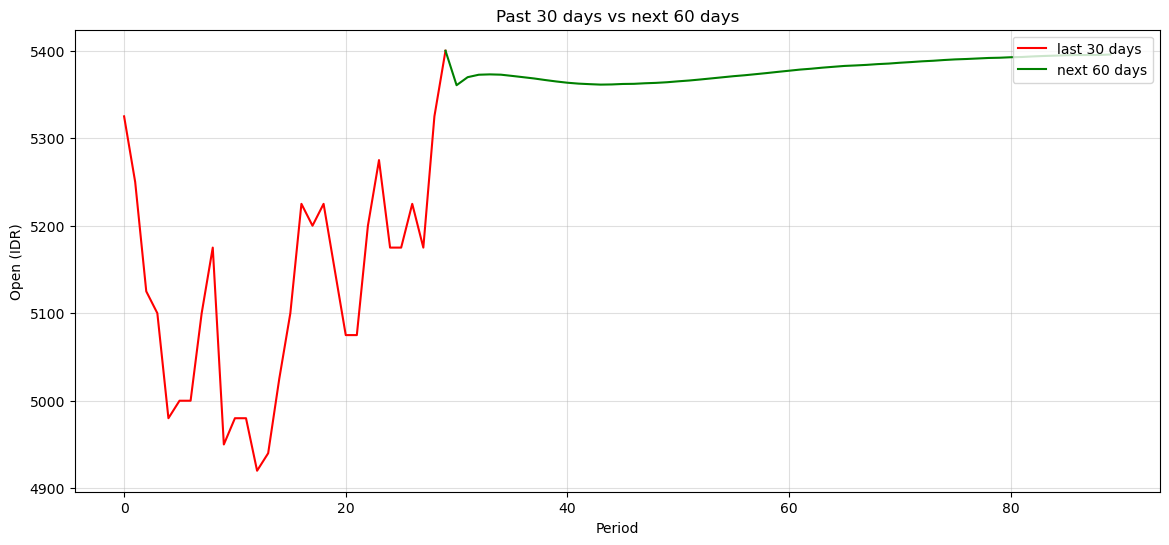

In [20]:
#Latest 30 days vs next 60 days forecasted
temp=np.array([None for i in range(t+iwannaforecast)])
temp[t-1]=scaler.inverse_transform(test)[len(test)-1][0]
temp[t:]=z.flatten()

fig, ax = plt.subplots(1,1, figsize=(14,6))
ax.plot(scaler.inverse_transform(test[-t:]), c="red", label="last 30 days")
ax.plot(temp, c="green", label="next 60 days")
ax.grid(alpha=0.4)
ax.set_title("Past 30 days vs next 60 days")
ax.legend(loc="upper right")
ax.set_ylabel("Open (IDR)")
ax.set_xlabel("Period")

Text(0.5, 0, 'Period')

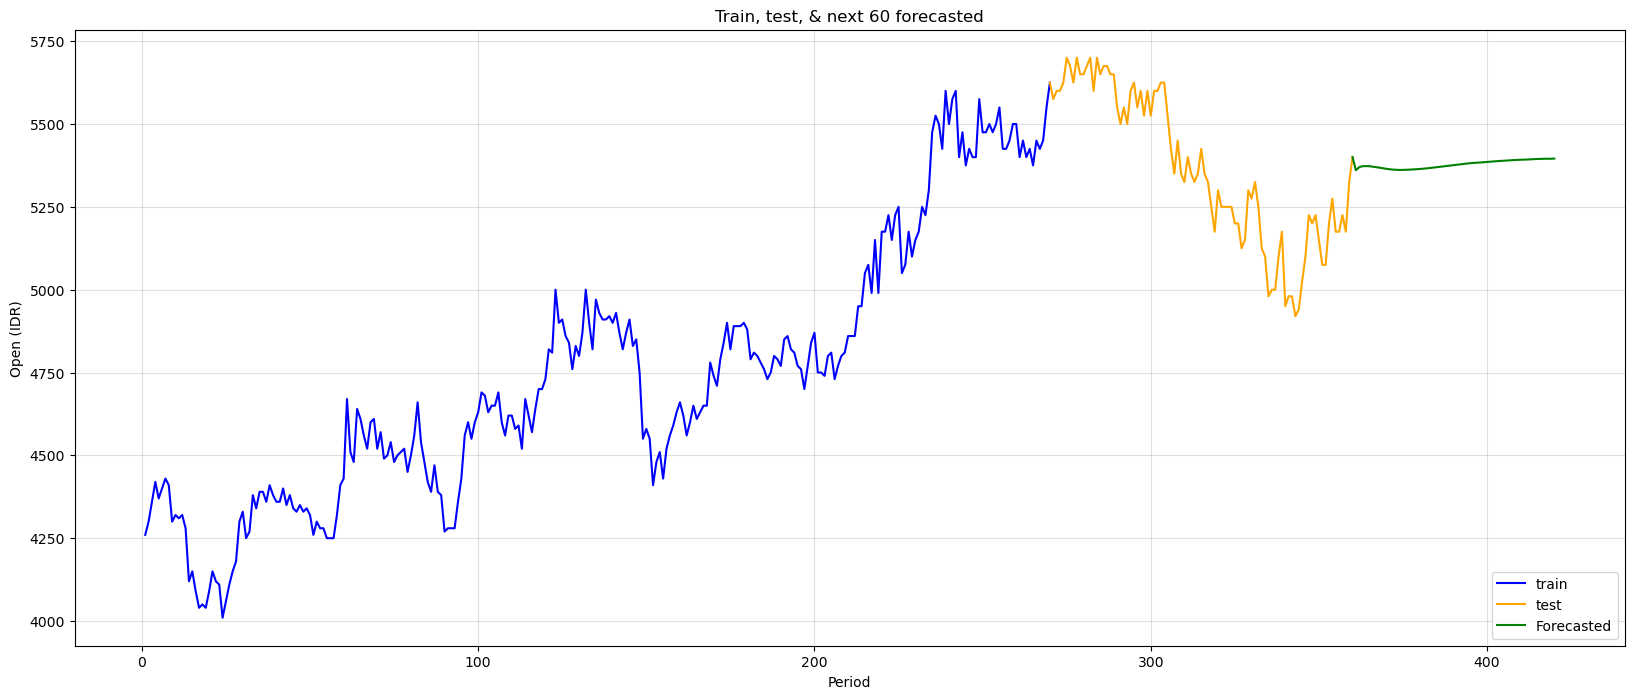

In [22]:
fig, ax = plt.subplots(1,1, figsize=(20,8))
temp=np.array(list(map(list, zip(train.flatten(), range(1,len(train)+1)))))
ax.plot(temp[:,1], scaler.inverse_transform(temp[:,0].reshape(-1, 1)), c="blue", label="train")

temp=np.array(list(map(list, zip(test.flatten(), range(len(train)+1,len(train)+len(test)+1)))))
temp=np.concatenate(([[train.flatten()[-1],len(train)]], temp),axis=0)

ax.plot(temp[:,1], scaler.inverse_transform(temp[:,0].reshape(-1, 1)), c="orange", label="test")

temp=np.array([None for i in range(len(df)+iwannaforecast+1)])
temp[len(df):]=scaler.inverse_transform(test)[len(test)-1][0]
temp[len(df)+1:]=z.flatten()
ax.plot(temp, c="green", label="Forecasted")

ax.legend(loc="lower right")
ax.set_title("Train, test, & next 60 forecasted")
ax.grid(alpha=0.4)
ax.set_ylabel("Open (IDR)")
ax.set_xlabel("Period")